<a href="https://colab.research.google.com/github/ShovalBenjer/deep_learning_neural_networks/blob/main/Deep_Learning_MNIST_From_Simple_Networks_to_CNN_Architectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MNIST Dataset Preparation**

This notebook section preprocesses the MNIST dataset for training, validation, and testing. The workflow includes:
1. **Transformations**: Normalize pixel values to [-1, 1] using a predefined transformation pipeline.
2. **Dataset Loading**: Load the MNIST training and testing datasets.
3. **Data Splitting**: Split the training dataset into 90% training and 10% validation subsets.
4. **DataLoader Creation**: Set up batch processing for each subset.

Below are reusable functions with proper docstrings to accomplish each step.


# **Model Implementation**

In this section, we define the two required models for the MNIST classification task:

1. **Logistic Regression Model**:
   - A single-layer model with a softmax output for multi-class classification.
   - Simple architecture without hidden layers.

2. **Two-Layer Neural Network**:
   - Two fully connected hidden layers with ReLU activation.
   - Softmax output for multi-class classification.

Both models are defined using PyTorch's `nn.Module` for flexibility and ease of integration. The `initialize_models` function initializes and returns instances of both models.


# **Evaluation Metrics and Analysis**

In this section, we evaluate the trained models using the following steps:

1. **Prediction Function**:
   - Takes a trained model and a DataLoader as input.
   - Returns predictions and ground truth labels.

2. **Evaluation Function**:
   - Computes metrics: Accuracy, Precision, Recall, F1 Score, and Confusion Matrix.
   - Designed to work with multiclass classification tasks.

3. **Visualization**:
   - Displays a confusion matrix for a better understanding of class-wise predictions.

### Workflow
1. Predict using the trained Logistic Regression and Two-Layer Neural Network models.
2. Evaluate their performance on the dataset.
3. Visualize and log results for detailed analysis.


## Phase 3 Overview

In **Phase 3**, we focus on comparing two fully connected (FC) architectures for MNIST digit classification:

1. **Logistic Regression Model**  
   - A single-layer model (no hidden layers) mapping 784 input pixels to 10 output classes.  
   - Uses a softmax output layer to handle multi-class classification.

2. **Two-Layer Neural Network**  
   - Two fully connected hidden layers, each with 200 neurons.  
   - Employs ReLU activation between layers.  
   - Ends with a softmax output layer for classification.

We train both models using the Adam optimizer for a fixed number of mini-batch updates (13,000 iterations, batch size of 50). We also split the official MNIST training set (60,000 images) into 90% for training (54,000) and 10% for validation (6,000), leaving the remaining 10,000 for testing.  

After training, we evaluate each model’s performance on the training, validation, and test sets. We log metrics (precision, recall, F1-score, accuracy) per class, show confusion matrices, and plot training/validation loss curves with Seaborn and Matplotlib.  

This phase demonstrates fundamental neural network training techniques and highlights the strengths and weaknesses of purely fully connected architectures on the MNIST dataset.

In [ ]:
%%bash
pip install seaborn scikit-learn torch torchvision matplotlib

In [ ]:
"""
This code snippet installs and imports everything needed to run the MNIST notebook,
defines a variety of helper functions for EDA, data preparation, plotting, and
includes only docstrings for clarity. Please run this snippet before the 'main'
snippet.
"""

import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score

torch.manual_seed(42)
np.random.seed(42)

def get_transforms():
    """
    Returns a torchvision transforms.Compose object that converts images to tensors
    and normalizes the MNIST dataset images to have mean 0.5 and std 0.5.

    :return: transforms.Compose for MNIST data.
    """
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

def load_mnist_dataset(transform):
    """
    Downloads and returns the MNIST train and test datasets using a given transform.

    :param transform: A transforms.Compose object containing image transformations.
    :return: (train_dataset, test_dataset) as PyTorch Dataset objects.
    """
    train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
    test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)
    return train_dataset, test_dataset

def split_train_validation(dataset, train_ratio=0.9):
    """
    Splits the given dataset into two subsets: train and validation. The size is
    based on train_ratio for the training subset and the remainder for validation.

    :param dataset: The dataset to split (e.g., 60k MNIST training images).
    :param train_ratio: The ratio of data to allocate for training.
    :return: (train_subset, val_subset) as PyTorch Subsets.
    """
    train_size = int(train_ratio * len(dataset))
    val_size = len(dataset) - train_size
    train_subset, val_subset = random_split(dataset, [train_size, val_size])
    return train_subset, val_subset

def create_dataloaders(train_subset, val_subset, test_dataset, batch_size=50):
    """
    Creates DataLoader objects for training, validation, and testing using the
    provided subsets and batch size.

    :param train_subset: A Subset for training data.
    :param val_subset: A Subset for validation data.
    :param test_dataset: A Dataset for test data.
    :param batch_size: Number of samples per batch.
    :return: (train_loader, val_loader, test_loader) DataLoader objects.
    """
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

def count_model_parameters(model):
    """
    Counts the total number of trainable parameters (weights + biases) for a given model.

    :param model: A PyTorch nn.Module whose parameters will be counted.
    :return: Integer representing the total number of trainable parameters.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class LogisticRegressionModel(nn.Module):
    """
    Defines a single-layer logistic regression model for MNIST classification
    with log_softmax output.
    """
    def __init__(self, input_size=784, num_classes=10):
        """
        Initializes a LogisticRegressionModel.

        :param input_size: The dimension of each input (784 for 28x28 images).
        :param num_classes: Number of output classes (10 for digits 0-9).
        """
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        """
        Forward pass that flattens the image and applies a linear transformation
        followed by log_softmax.

        :param x: Input tensor of shape (N, 1, 28, 28).
        :return: Log probabilities of shape (N, num_classes).
        """
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.linear(x), dim=1)

class TwoLayerNNModel(nn.Module):
    """
    Defines a two-layer fully connected neural network for MNIST classification
    with ReLU activations and log_softmax output.
    """
    def __init__(self, input_size=784, hidden_size=200, num_classes=10):
        """
        Initializes a TwoLayerNNModel.

        :param input_size: The dimension of each input (784 for 28x28 images).
        :param hidden_size: Number of neurons in each hidden layer (default 200).
        :param num_classes: Number of output classes (10 for digits 0-9).
        """
        super(TwoLayerNNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        """
        Forward pass that flattens the image, applies two FC-ReLU layers, and ends
        with a log_softmax output.

        :param x: Input tensor of shape (N, 1, 28, 28).
        :return: Log probabilities of shape (N, num_classes).
        """
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.log_softmax(self.output(x), dim=1)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_iterations=13000):
    """
    Trains the given model using mini-batch gradient descent with Adam and tracks
    both training and validation losses for plotting.

    :param model: The PyTorch nn.Module to train.
    :param train_loader: A DataLoader object for the training subset.
    :param val_loader: A DataLoader object for the validation subset.
    :param criterion: The loss function (e.g., nn.CrossEntropyLoss).
    :param optimizer: The PyTorch optimizer (e.g., torch.optim.Adam).
    :param num_iterations: Total number of mini-batch updates to perform.
    :return: (training_losses, validation_losses) lists that track losses over time.
    """
    """
    Note: We gather validation loss at the end of each epoch, not each iteration.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    train_losses = []
    val_losses = []
    iteration = 0
    epoch = 0
    start_time = time.time()

    while iteration < num_iterations:
        epoch += 1
        batch_losses = []
        for images, labels in train_loader:
            if iteration >= num_iterations:
                break
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())
            iteration += 1
            if iteration % 100 == 0:
                print(f"Iteration [{iteration}/{num_iterations}], Loss: {loss.item():.4f}")

        if len(batch_losses) > 0:
            epoch_train_loss = np.mean(batch_losses)
            train_losses.append(epoch_train_loss)

            model.eval()
            with torch.no_grad():
                val_batch_losses = []
                for v_images, v_labels in val_loader:
                    v_images, v_labels = v_images.to(device), v_labels.to(device)
                    v_outputs = model(v_images)
                    v_loss = criterion(v_outputs, v_labels)
                    val_batch_losses.append(v_loss.item())
            model.train()
            epoch_val_loss = np.mean(val_batch_losses)
            val_losses.append(epoch_val_loss)

    end_time = time.time()
    print(f"Training completed in {end_time - start_time:.2f} seconds.")
    return train_losses, val_losses

def predict(model, data_loader):
    """
    Generates predictions (argmax) using a trained model on a given DataLoader.

    :param model: A trained PyTorch nn.Module.
    :param data_loader: A DataLoader object for the dataset to predict on.
    :return: (y_true, y_pred) - lists of ground truth labels and predicted labels.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy().tolist())
            y_pred.extend(preds.cpu().numpy().tolist())
    return y_true, y_pred

def plot_loss_curves(train_losses, val_losses):
    """
    Plots the training and validation loss curves over epochs using Matplotlib.

    :param train_losses: A list of average training losses per epoch.
    :param val_losses: A list of average validation losses per epoch.
    :return: None (displays a plot).
    """
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss Over Time')
    plt.legend()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, set_name="Unknown"):
    """
    Plots a confusion matrix using Seaborn's heatmap.

    :param y_true: A list of ground truth labels.
    :param y_pred: A list of predicted labels.
    :param set_name: Name of the set (Train/Validation/Test).
    :return: None (displays a plot).
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f'Confusion Matrix ({set_name} Set)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def plot_classification_metrics(y_true, y_pred, num_classes=10, set_name="Unknown"):
    """
    Parses the classification report (precision, recall, f1-score) for each class,
    and plots them as barplots using Seaborn.

    :param y_true: A list of ground truth labels.
    :param y_pred: A list of predicted labels.
    :param num_classes: Number of classes (10 for MNIST).
    :param set_name: Name of the set (Train/Validation/Test).
    :return: None (displays a bar plot).
    """
    report_dict = classification_report(y_true, y_pred, labels=range(num_classes), output_dict=True)
    metrics = ["precision", "recall", "f1-score"]
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    for i, metric in enumerate(metrics):
        values = [report_dict[str(c)][metric] for c in range(num_classes) if str(c) in report_dict]
        sns.barplot(x=list(range(num_classes)), y=values, ax=axes[i])
        axes[i].set_title(f"{metric.capitalize()} per Class - {set_name}")
        axes[i].set_xlabel("Class")
        axes[i].set_ylabel(metric.capitalize())
    plt.show()

def print_balanced_accuracy(y_true, y_pred, set_name="Unknown"):
    """
    Computes and prints the balanced accuracy for a given set's predictions.

    :param y_true: List of true labels.
    :param y_pred: List of predicted labels.
    :param set_name: Name of the set for logging (Train, Validation, Test).
    :return: None (prints the balanced accuracy).
    """
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    print(f"Balanced Accuracy ({set_name}): {bal_acc:.4f}")

def print_classification_report_sklearn(y_true, y_pred, set_name="Unknown"):
    """
    Prints the sklearn classification report, including precision, recall, f1-score,
    and support for each class.

    :param y_true: List of ground truth labels.
    :param y_pred: List of predicted labels.
    :param set_name: Name of the set for output labeling.
    :return: None (prints to stdout).
    """
    print(f"=== Classification Report for {set_name} Set ===")
    report = classification_report(y_true, y_pred, digits=4)
    print(report)


Using device: cpu
Parameters (Logistic Regression): 7850
Parameters (Two-Layer NN): 199210

Training Logistic Regression...
Iteration [100/13000], Loss: 0.6623
Iteration [200/13000], Loss: 0.5356
Iteration [300/13000], Loss: 0.3193
Iteration [400/13000], Loss: 0.4555
Iteration [500/13000], Loss: 0.3166
Iteration [600/13000], Loss: 0.4591
Iteration [700/13000], Loss: 0.3950
Iteration [800/13000], Loss: 0.1956
Iteration [900/13000], Loss: 0.2112
Iteration [1000/13000], Loss: 0.2503
Iteration [1100/13000], Loss: 0.3529
Iteration [1200/13000], Loss: 0.6120
Iteration [1300/13000], Loss: 0.2078
Iteration [1400/13000], Loss: 0.1167
Iteration [1500/13000], Loss: 0.6150
Iteration [1600/13000], Loss: 0.7475
Iteration [1700/13000], Loss: 0.2726
Iteration [1800/13000], Loss: 0.2490
Iteration [1900/13000], Loss: 0.2750
Iteration [2000/13000], Loss: 0.3081
Iteration [2100/13000], Loss: 0.5066
Iteration [2200/13000], Loss: 0.2947
Iteration [2300/13000], Loss: 0.2698
Iteration [2400/13000], Loss: 0.56

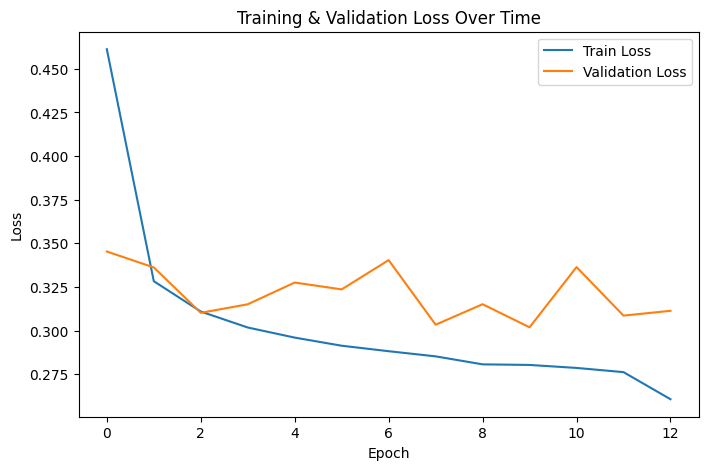

Plotting Loss Curves for Two-Layer NN:


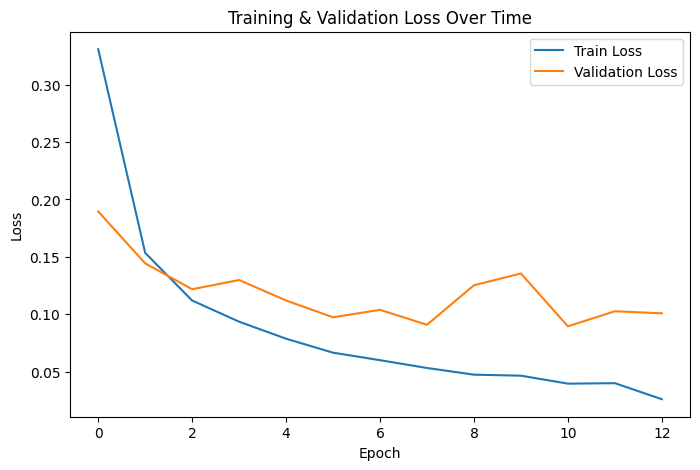


EVALUATING MODELS...

=== Logistic Regression ===
=== Classification Report for Train Set ===
              precision    recall  f1-score   support

           0     0.9610    0.9749    0.9679      5340
           1     0.9555    0.9755    0.9654      6076
           2     0.9273    0.9119    0.9195      5383
           3     0.8964    0.9145    0.9054      5509
           4     0.9312    0.9367    0.9340      5246
           5     0.8784    0.8976    0.8879      4903
           6     0.9593    0.9557    0.9575      5308
           7     0.9734    0.8870    0.9282      5609
           8     0.9275    0.8519    0.8881      5254
           9     0.8480    0.9399    0.8916      5372

    accuracy                         0.9253     54000
   macro avg     0.9258    0.9246    0.9245     54000
weighted avg     0.9267    0.9253    0.9254     54000

Balanced Accuracy (Train): 0.9246


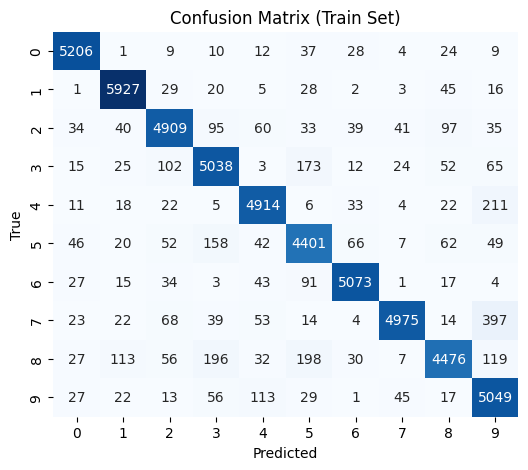

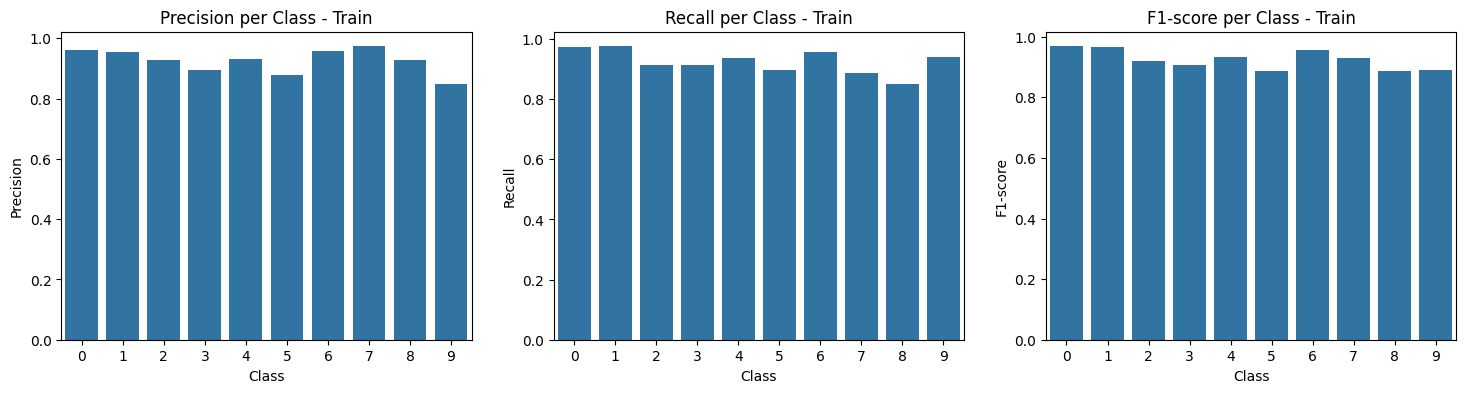

=== Classification Report for Validation Set ===
              precision    recall  f1-score   support

           0     0.9521    0.9537    0.9529       583
           1     0.9502    0.9745    0.9622       666
           2     0.9054    0.8817    0.8934       575
           3     0.8672    0.8923    0.8796       622
           4     0.9109    0.9262    0.9185       596
           5     0.8428    0.8900    0.8657       518
           6     0.9662    0.9377    0.9517       610
           7     0.9654    0.8933    0.9279       656
           8     0.9270    0.8509    0.8873       597
           9     0.8167    0.8960    0.8545       577

    accuracy                         0.9105      6000
   macro avg     0.9104    0.9096    0.9094      6000
weighted avg     0.9124    0.9105    0.9108      6000

Balanced Accuracy (Validation): 0.9096


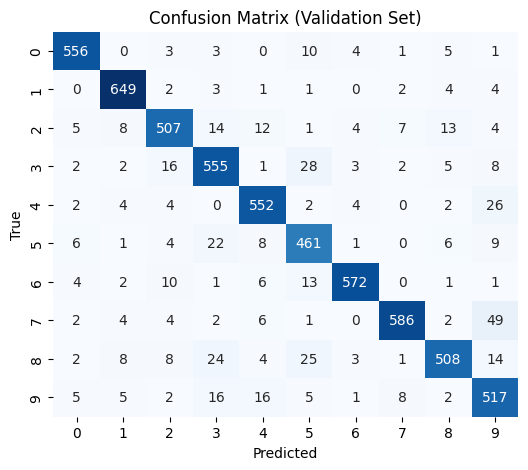

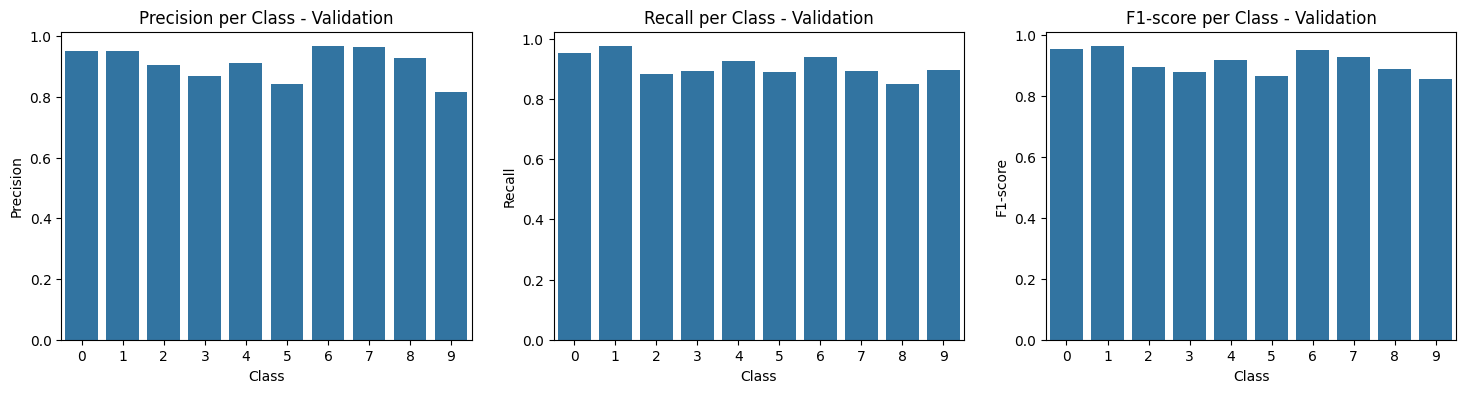

=== Classification Report for Test Set ===
              precision    recall  f1-score   support

           0     0.9460    0.9827    0.9640       980
           1     0.9626    0.9762    0.9694      1135
           2     0.9235    0.9012    0.9122      1032
           3     0.8840    0.9208    0.9020      1010
           4     0.9253    0.9328    0.9290       982
           5     0.8770    0.8789    0.8779       892
           6     0.9484    0.9395    0.9439       958
           7     0.9657    0.8765    0.9189      1028
           8     0.9042    0.8429    0.8725       974
           9     0.8579    0.9336    0.8942      1009

    accuracy                         0.9195     10000
   macro avg     0.9195    0.9185    0.9184     10000
weighted avg     0.9204    0.9195    0.9194     10000

Balanced Accuracy (Test): 0.9185


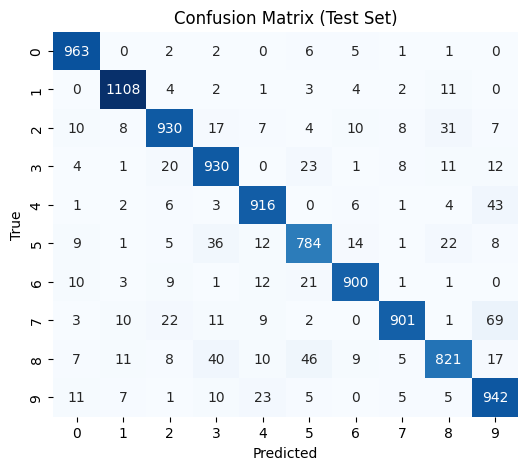

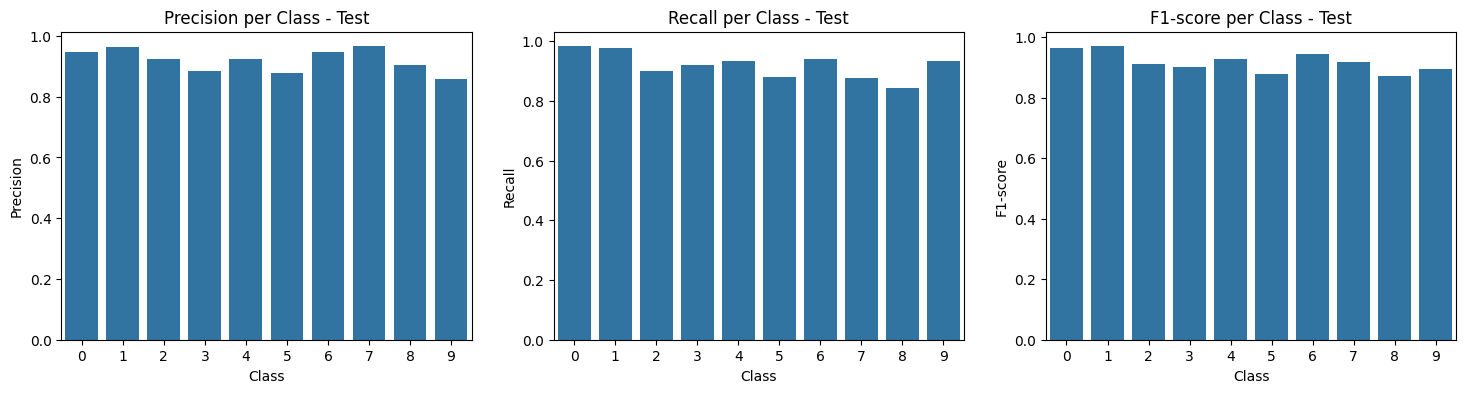


=== Two-Layer NN ===
=== Classification Report for Train Set ===
              precision    recall  f1-score   support

           0     0.9977    0.9938    0.9958      5340
           1     0.9966    0.9781    0.9873      6076
           2     0.9963    0.9872    0.9917      5383
           3     0.9858    0.9942    0.9900      5509
           4     0.9859    0.9968    0.9913      5246
           5     0.9935    0.9908    0.9921      4903
           6     0.9955    0.9964    0.9960      5308
           7     0.9943    0.9889    0.9916      5609
           8     0.9734    0.9901    0.9817      5254
           9     0.9846    0.9894    0.9870      5372

    accuracy                         0.9904     54000
   macro avg     0.9904    0.9906    0.9904     54000
weighted avg     0.9905    0.9904    0.9904     54000

Balanced Accuracy (Train): 0.9906


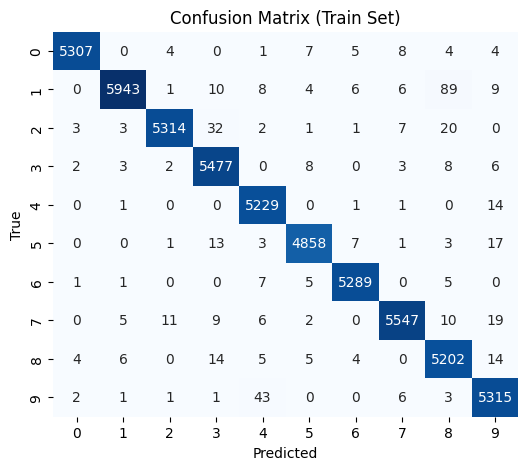

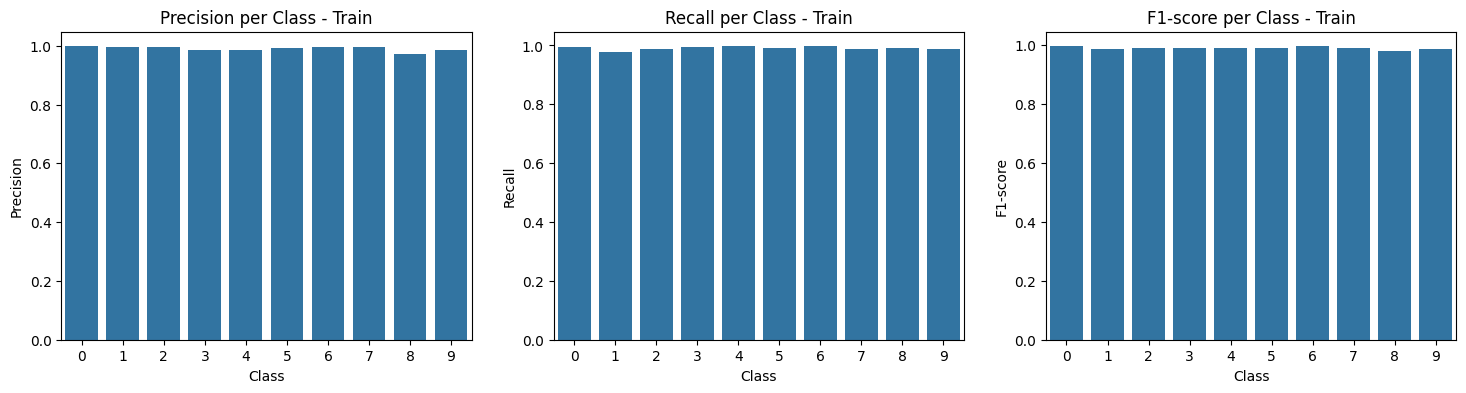

=== Classification Report for Validation Set ===
              precision    recall  f1-score   support

           0     0.9913    0.9777    0.9845       583
           1     0.9969    0.9715    0.9840       666
           2     0.9839    0.9548    0.9691       575
           3     0.9544    0.9759    0.9650       622
           4     0.9468    0.9849    0.9655       596
           5     0.9677    0.9826    0.9751       518
           6     0.9835    0.9787    0.9811       610
           7     0.9772    0.9817    0.9795       656
           8     0.9450    0.9497    0.9474       597
           9     0.9632    0.9515    0.9573       577

    accuracy                         0.9710      6000
   macro avg     0.9710    0.9709    0.9708      6000
weighted avg     0.9713    0.9710    0.9710      6000

Balanced Accuracy (Validation): 0.9709


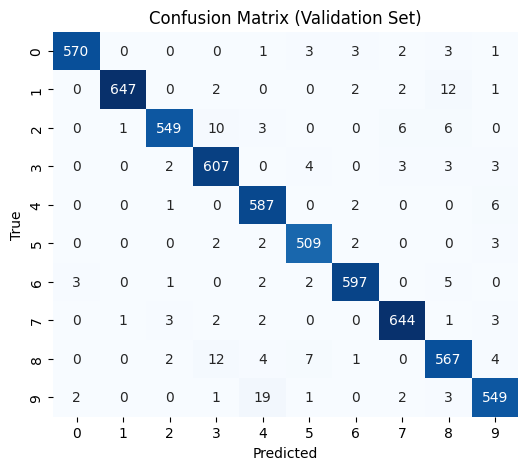

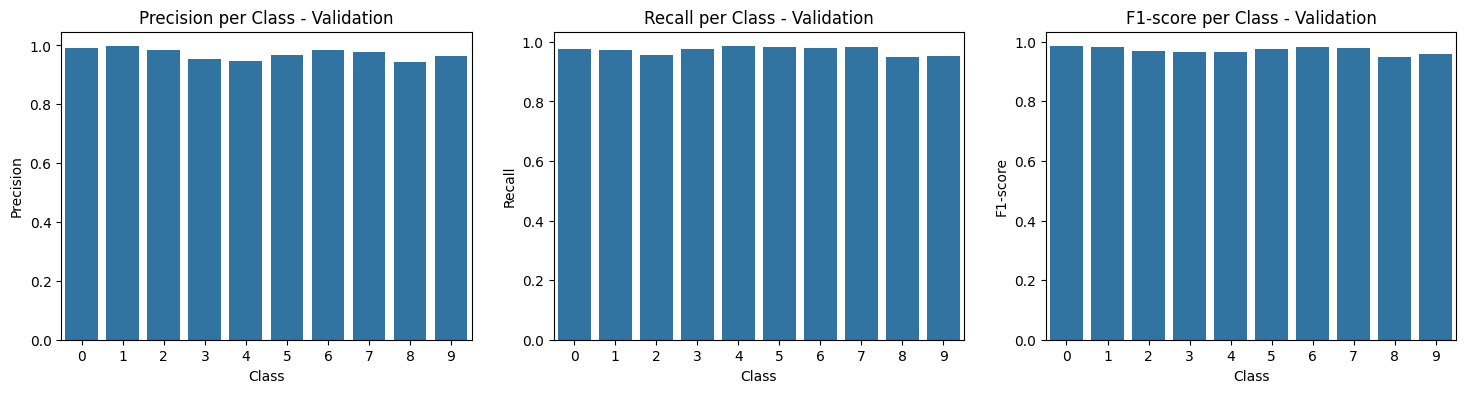

=== Classification Report for Test Set ===
              precision    recall  f1-score   support

           0     0.9908    0.9847    0.9877       980
           1     0.9901    0.9709    0.9804      1135
           2     0.9861    0.9641    0.9750      1032
           3     0.9495    0.9861    0.9675      1010
           4     0.9641    0.9857    0.9748       982
           5     0.9763    0.9686    0.9724       892
           6     0.9801    0.9781    0.9791       958
           7     0.9842    0.9669    0.9755      1028
           8     0.9516    0.9692    0.9603       974
           9     0.9683    0.9673    0.9678      1009

    accuracy                         0.9741     10000
   macro avg     0.9741    0.9742    0.9741     10000
weighted avg     0.9744    0.9741    0.9741     10000

Balanced Accuracy (Test): 0.9742


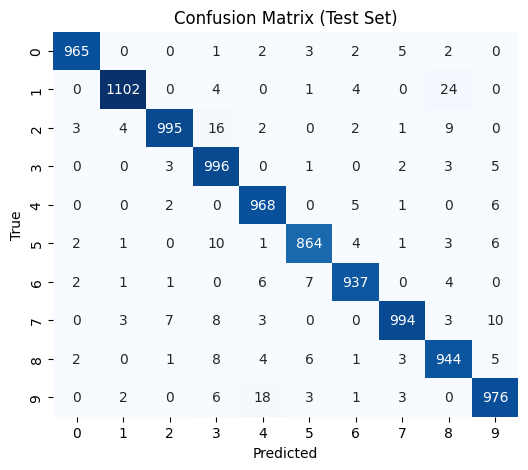

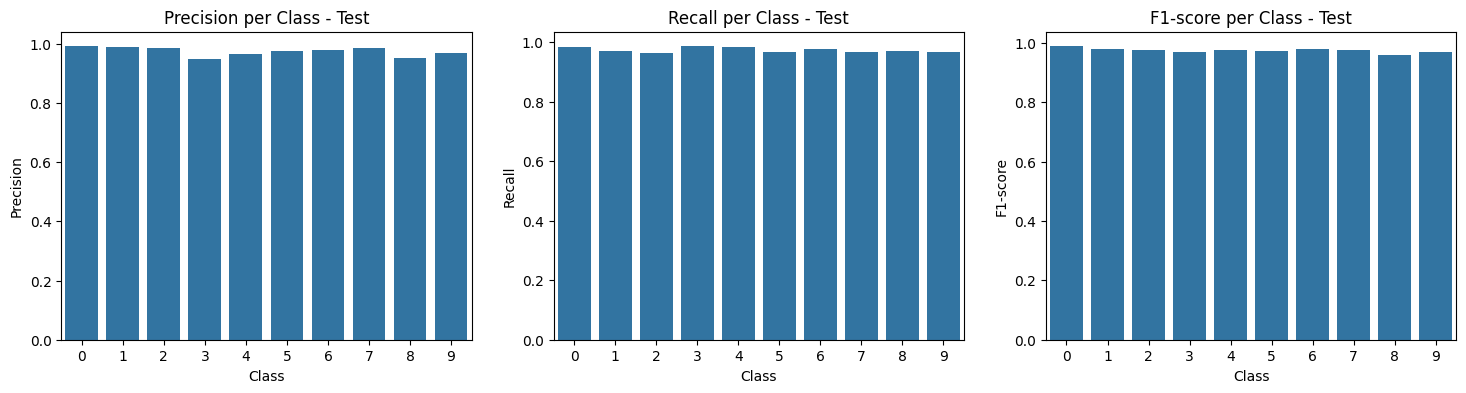

In [ ]:
"""
This code snippet orchestrates the entire process:
1) Loads MNIST data and splits into train/validation/test.
2) Performs EDA.
3) Initializes and trains two models (Logistic Regression & Two-Layer NN).
4) Evaluates and visualizes results on train/validation/test sets.
Please ensure you have already run Snippet #1 in your environment before running this.
"""

def main():
    """
    Main function that executes:
    - Data loading and splitting
    - EDA
    - Model instantiation
    - Training on train data
    - Evaluation (metrics + plots) on train, val, test
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    transform = get_transforms()
    full_train_dataset, test_dataset = load_mnist_dataset(transform)
    train_subset, val_subset = split_train_validation(full_train_dataset, train_ratio=0.9)
    train_loader, val_loader, test_loader = create_dataloaders(train_subset, val_subset, test_dataset, batch_size=50)

    input_size = 784
    num_classes = 10
    hidden_size = 200
    learning_rate = 0.001
    num_iterations = 13000

    logistic_model = LogisticRegressionModel(input_size, num_classes)
    two_layer_model = TwoLayerNNModel(input_size, hidden_size, num_classes)

    print("Parameters (Logistic Regression):", count_model_parameters(logistic_model))
    print("Parameters (Two-Layer NN):", count_model_parameters(two_layer_model))

    criterion = nn.CrossEntropyLoss()
    optimizer_logistic = torch.optim.Adam(logistic_model.parameters(), lr=learning_rate)
    optimizer_nn = torch.optim.Adam(two_layer_model.parameters(), lr=learning_rate)

    print("\nTraining Logistic Regression...")
    log_train_losses, log_val_losses = train_model(logistic_model, train_loader, val_loader,
                                                   criterion, optimizer_logistic, num_iterations)

    print("\nTraining Two-Layer NN...")
    nn_train_losses, nn_val_losses = train_model(two_layer_model, train_loader, val_loader,
                                                 criterion, optimizer_nn, num_iterations)

    print("\nPlotting Loss Curves for Logistic Regression:")
    plot_loss_curves(log_train_losses, log_val_losses)

    print("Plotting Loss Curves for Two-Layer NN:")
    plot_loss_curves(nn_train_losses, nn_val_losses)

    print("\nEVALUATING MODELS...")

    for model_name, model_obj in [("Logistic Regression", logistic_model),
                                  ("Two-Layer NN", two_layer_model)]:
        print(f"\n=== {model_name} ===")

        y_true_train, y_pred_train = predict(model_obj, train_loader)
        y_true_val, y_pred_val = predict(model_obj, val_loader)
        y_true_test, y_pred_test = predict(model_obj, test_loader)

        print_classification_report_sklearn(y_true_train, y_pred_train, set_name="Train")
        print_balanced_accuracy(y_true_train, y_pred_train, set_name="Train")
        plot_confusion_matrix(y_true_train, y_pred_train, set_name="Train")
        plot_classification_metrics(y_true_train, y_pred_train, set_name="Train")

        print_classification_report_sklearn(y_true_val, y_pred_val, set_name="Validation")
        print_balanced_accuracy(y_true_val, y_pred_val, set_name="Validation")
        plot_confusion_matrix(y_true_val, y_pred_val, set_name="Validation")
        plot_classification_metrics(y_true_val, y_pred_val, set_name="Validation")

        print_classification_report_sklearn(y_true_test, y_pred_test, set_name="Test")
        print_balanced_accuracy(y_true_test, y_pred_test, set_name="Test")
        plot_confusion_matrix(y_true_test, y_pred_test, set_name="Test")
        plot_classification_metrics(y_true_test, y_pred_test, set_name="Test")

if __name__ == "__main__":
    main()


## Phase 4 Overview

In **Phase 4**, we introduce **Convolutional Neural Networks (CNNs)** to enhance digit classification for MNIST. We experiment with:

1. **Single Convolution Layer**  
   - A single Conv2D (5×5 kernel, stride=1, padding=2) followed by a 2×2 max-pooling layer (stride=2).  
   - A fully connected layer (1024 neurons) with ReLU activation, plus an output layer for classification.  

2. **Double Convolution Layer**  
   - Two consecutive convolution + ReLU + max-pooling stages, each with 5×5 kernels and 2×2 pooling.  
   - A large fully connected layer (1024 neurons), and a final linear layer for classification.  

3. **Double Convolution with Dropout**  
   - Same as above, but with 50% dropout applied to the fully connected layer.  

We compare training with **batch sizes** of **50** vs. **100**, tracking how many iterations and how long it takes to reach **99%** validation accuracy. We then identify which architecture achieves the best **balanced accuracy** on the validation set and further inspect its convolution filters and feature maps:

- **Filter Visualization**: We show the learned convolution filters of the best CNN.  
- **Activation Maps**: We display the outputs of specific channels before and after ReLU.  
- **Original Images**: We include the corresponding input images that generated these feature maps.  

By incorporating convolutional layers, pooling, and optional dropout, we explore advanced approaches that typically outperform standard fully connected models on image data. This deeper look at CNN internals—filter weights and intermediate layer activations—provides insight into how convolution kernels capture spatial patterns in MNIST digits.

In [ ]:
"""
This snippet installs, imports, and defines all utility functions, classes, and transformations
needed for ex_4. It contains no external comments, only docstrings (PEP 8 style) within functions.

Run this snippet first, then proceed to Snippet #2 for the main execution flow.
"""

# Install required libraries (only needed if not already installed in your environment).
# You can comment it out if you already have them installed.
# %%bash
# pip install seaborn scikit-learn torch torchvision matplotlib

import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score, accuracy_score

torch.manual_seed(42)
np.random.seed(42)

def get_transforms():
    """
    Returns a torchvision transforms.Compose object that converts images to tensors
    and normalizes pixel values to the range [-1, 1] by using mean=0.5, std=0.5.

    :return: A transforms.Compose for MNIST data.
    """
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

def load_mnist_dataset(transform, train=True):
    """
    Loads the MNIST dataset given a transform, optionally for train or test.

    :param transform: A transform or composition of transforms.
    :param train: Boolean indicating whether to load the training set (True) or test set (False).
    :return: A torchvision MNIST dataset object.
    """
    return datasets.MNIST(root="./data_ex4", train=train, transform=transform, download=True)

def split_train_validation(dataset, train_ratio=0.9):
    """
    Splits a dataset into two subsets: train and validation, according to the train_ratio.
    For example, if train_ratio=0.9, then 90% of dataset is used for training, 10% for validation.

    :param dataset: The dataset to split.
    :param train_ratio: Float proportion for the train subset.
    :return: (train_subset, val_subset) as PyTorch Subset objects.
    """
    train_size = int(train_ratio * len(dataset))
    val_size = len(dataset) - train_size
    return random_split(dataset, [train_size, val_size])

def create_dataloaders(train_subset, val_subset, test_dataset, batch_size=50):
    """
    Creates DataLoader objects for train, validation, and test sets from the given subsets/dataset
    and specified batch size.

    :param train_subset: A Subset containing training data.
    :param val_subset: A Subset containing validation data.
    :param test_dataset: A Dataset for test data.
    :param batch_size: Integer batch size for the returned DataLoaders.
    :return: (train_loader, val_loader, test_loader).
    """
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

def single_conv_net():
    """
    Returns an instance of a model with one convolutional layer (5x5 kernel, stride=1, padding=2),
    followed by a 2x2 max pool (stride=2), then a fully connected layer of size 1024 with ReLU,
    and a final linear layer for 10 classes.

    :return: A torch.nn.Module representing the SingleConvNet architecture.
    """
    class SingleConvNet(nn.Module):
        """
        Defines a single-conv-layer architecture with the specified convolution, pooling,
        a 1024-neuron FC layer, and final log-softmax for MNIST classification.
        """
        def __init__(self):
            super(SingleConvNet, self).__init__()
            self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=5, stride=1, padding=2)
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.fc1 = nn.Linear(5*14*14, 1024)
            self.fc2 = nn.Linear(1024, 10)

        def forward(self, x):
            """
            Implements forward pass of the single convolution net:
            conv -> ReLU -> max pool -> flatten -> FC(1024) -> ReLU -> FC(10) -> log_softmax.

            :param x: Tensor of shape (N, 1, 28, 28).
            :return: Log probabilities of shape (N, 10).
            """
            x = F.relu(self.conv1(x))
            x = self.pool1(x)
            x = x.view(x.size(0), -1)
            x = F.relu(self.fc1(x))
            return F.log_softmax(self.fc2(x), dim=1)

    return SingleConvNet()

def double_conv_net(add_dropout=False):
    """
    Returns an instance of a model with two convolutional layers (5x5 kernel, stride=1, padding=2),
    each followed by ReLU and 2x2 max pooling with stride=2. After flattening, a 1024-neuron FC layer
    with optional dropout is applied, followed by ReLU, and a final linear layer for 10 classes.

    :param add_dropout: Boolean indicating whether to apply 0.5 dropout before the FC layer.
    :return: A torch.nn.Module representing the DoubleConvNet architecture.
    """
    class DoubleConvNet(nn.Module):
        """
        Defines a two-conv-layer architecture. Each conv is 5x5 with stride=1, same padding=2,
        followed by ReLU and 2x2 max pool. Optionally applies dropout(0.5) before the FC layer.
        """
        def __init__(self, add_dropout_flag=add_dropout):
            super(DoubleConvNet, self).__init__()
            self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=5, stride=1, padding=2)
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.conv2 = nn.Conv2d(in_channels=5, out_channels=5, kernel_size=5, stride=1, padding=2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.dropout = nn.Dropout(0.5) if add_dropout_flag else nn.Identity()
            self.fc1 = nn.Linear(5*7*7, 1024)
            self.fc2 = nn.Linear(1024, 10)

        def forward(self, x):
            """
            Implements forward pass of the double convolution net:
            conv1->ReLU->pool1->conv2->ReLU->pool2->(optional dropout)->flatten->fc1->ReLU->fc2->log_softmax.

            :param x: Tensor of shape (N, 1, 28, 28).
            :return: Log probabilities of shape (N, 10).
            """
            x = F.relu(self.conv1(x))
            x = self.pool1(x)
            x = F.relu(self.conv2(x))
            x = self.pool2(x)
            x = self.dropout(x)
            x = x.view(x.size(0), -1)
            x = F.relu(self.fc1(x))
            return F.log_softmax(self.fc2(x), dim=1)

    return DoubleConvNet(add_dropout)

def train_ex4(model, train_loader, val_loader, optimizer, criterion, max_epochs=20, target_val_accuracy=0.99, verbose=True):
    """
    Trains the given model on a train_loader while periodically checking validation accuracy
    to see if it meets or exceeds target_val_accuracy. Stops training early if reached.

    :param model: A torch.nn.Module to train.
    :param train_loader: DataLoader for training data.
    :param val_loader: DataLoader for validation data.
    :param optimizer: Torch optimizer (e.g., Adam).
    :param criterion: Loss function (e.g., CrossEntropyLoss).
    :param max_epochs: Maximum number of epochs to run.
    :param target_val_accuracy: Stop training early if this validation accuracy is reached.
    :param verbose: Boolean controlling whether to print progress to screen.
    :return: (best_val_acc, iters_taken, total_time) where best_val_acc is the best validation
             accuracy reached, iters_taken is the total training iterations, total_time is in seconds.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    iters_taken = 0
    best_val_acc = 0.0
    start = time.time()

    for epoch in range(max_epochs):
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            iters_taken += 1

        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images_v, labels_v in val_loader:
                images_v, labels_v = images_v.to(device), labels_v.to(device)
                outputs_v = model(images_v)
                _, preds_v = torch.max(outputs_v, dim=1)
                val_correct += (preds_v == labels_v).sum().item()
                val_total += len(labels_v)
        current_val_acc = val_correct / val_total
        if current_val_acc > best_val_acc:
            best_val_acc = current_val_acc
        if verbose:
            print(f"Epoch={epoch+1}, ValAcc={current_val_acc:.4f}, Best={best_val_acc:.4f}")
        model.train()
        if best_val_acc >= target_val_accuracy:
            break

    total_time = time.time() - start
    return best_val_acc, iters_taken, total_time

def evaluate_ex4(model, data_loader):
    """
    Evaluates a trained model on a given DataLoader. Returns (accuracy, balanced_accuracy).

    :param model: Torch nn.Module to evaluate.
    :param data_loader: DataLoader for the dataset on which to evaluate.
    :return: (acc, bal_acc) floats.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

    acc = accuracy_score(all_labels, all_preds)
    bal_acc = balanced_accuracy_score(all_labels, all_preds)
    return acc, bal_acc

def image_conv(model, x_batch, layer_index, channel_index, after_relu=False):
    """
    Visualizes the output of a specific channel from a specified convolution layer in the model,
    optionally after ReLU. If after_relu=True, the layer's activation is computed; if False, we
    capture the pre-ReLU result. Plots the chosen channel of one image in the batch.

    :param model: A torch.nn.Module with convolution layers.
    :param x_batch: A batch of images (tensor shape: (N, 1, 28, 28)).
    :param layer_index: The index of the convolution layer in the model (0-based).
    :param channel_index: The index of the channel to visualize in that layer's output.
    :param after_relu: Boolean indicating whether to capture the activation after ReLU.
    :return: None (displays a matplotlib plot).
    """
    """
    Note: This function uses forward hooks to capture the layer's output.
    You may adjust indexing if your model has multiple layers or skip ReLU for direct conv output.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    activation = {}
    def hook_fn(_, __, output):
        activation["convout"] = output.detach()

    modules_list = list(model.modules())
    conv_list = [m for m in modules_list if isinstance(m, nn.Conv2d)]
    relu_list = [m for m in modules_list if isinstance(m, nn.ReLU)]

    chosen_layer = None
    if after_relu and layer_index < len(relu_list):
        chosen_layer = relu_list[layer_index]
    elif not after_relu and layer_index < len(conv_list):
        chosen_layer = conv_list[layer_index]

    if chosen_layer is None:
        return

    handle = chosen_layer.register_forward_hook(hook_fn)
    x_batch = x_batch.to(device)
    _ = model(x_batch)
    handle.remove()

    output_tensor = activation["convout"].cpu()
    if output_tensor.dim() == 4 and output_tensor.size(1) > channel_index:
        chosen_image = 0
        feature_map = output_tensor[chosen_image, channel_index]
        plt.figure()
        plt.imshow(feature_map.numpy(), cmap="gray")
        label_str = "After ReLU" if after_relu else "Before ReLU"
        plt.title(f"Layer={layer_index}, Channel={channel_index}, {label_str}")
        plt.axis("off")
        plt.show()

def visualize_filters(model, layer_index=0):
    """
    Visualizes the convolution filter weights of a specific convolution layer in the given model.

    :param model: A torch.nn.Module containing convolutional layers.
    :param layer_index: Index of the convolution layer for which we visualize filters.
    :return: None (plots filter weights via matplotlib).
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    conv_list = [m for m in model.modules() if isinstance(m, nn.Conv2d)]
    if layer_index >= len(conv_list):
        return

    conv_layer = conv_list[layer_index]
    weights = conv_layer.weight.detach().cpu().numpy()

    num_filters = weights.shape[0]
    fig, axes = plt.subplots(1, num_filters, figsize=(3*num_filters, 3))
    if num_filters == 1:
        axes = [axes]
    for i in range(num_filters):
        axes[i].imshow(weights[i, 0], cmap="gray")
        axes[i].set_title(f"Filter {i}")
        axes[i].axis("off")
    plt.show()

Using device: cpu
Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.76MB/s]


Extracting ./data_ex4/MNIST/raw/train-images-idx3-ubyte.gz to ./data_ex4/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 154kB/s]


Extracting ./data_ex4/MNIST/raw/train-labels-idx1-ubyte.gz to ./data_ex4/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.45MB/s]


Extracting ./data_ex4/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data_ex4/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.41MB/s]


Extracting ./data_ex4/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data_ex4/MNIST/raw


=== Training SingleConv with batch_size=50 ===
Epoch=1, ValAcc=0.9775, Best=0.9775
Epoch=2, ValAcc=0.9788, Best=0.9788
Epoch=3, ValAcc=0.9843, Best=0.9843
Epoch=4, ValAcc=0.9860, Best=0.9860
Epoch=5, ValAcc=0.9842, Best=0.9860
Epoch=6, ValAcc=0.9858, Best=0.9860
Epoch=7, ValAcc=0.9860, Best=0.9860
Epoch=8, ValAcc=0.9852, Best=0.9860
Epoch=9, ValAcc=0.9828, Best=0.9860
Epoch=10, ValAcc=0.9875, Best=0.9875
Epoch=11, ValAcc=0.9848, Best=0.9875
Epoch=12, ValAcc=0.9870, Best=0.9875
Epoch=13, ValAcc=0.9863, Best=0.9875
Epoch=14, ValAcc=0.9823, Best=0.9875
Epoch=15, ValAcc=0.9870, Best=0.9875
Epoch=16, ValAcc=0.9885, Best=0.9885
Epoch=17, ValAcc=0.9883, Best=0.9885
Epoch=18, ValAcc=0.9858, Best=0.9885
Epoch=19, ValAcc=0.9860, Best=0.9885
Epoch=20, ValAcc=0.9838, Best=0.9885
Batch=50, Achieved ValAcc=0.9838, BalValAcc=0.9836, Time=946.60s, Iters=21600

=== Training SingleConv with batch_size=100 ===
Epoch=1, Va

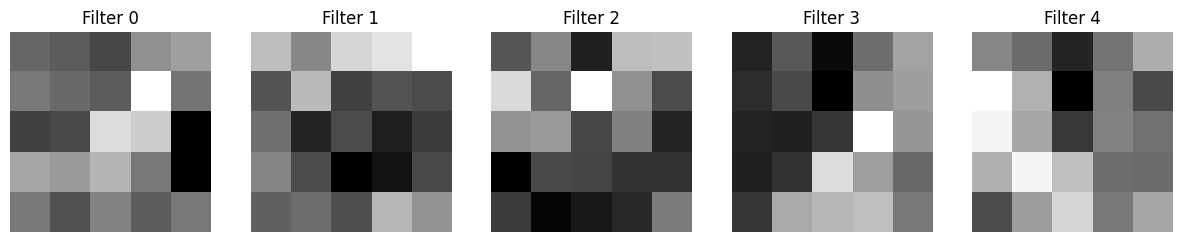

Displaying sample original images used for conv activation visualization:


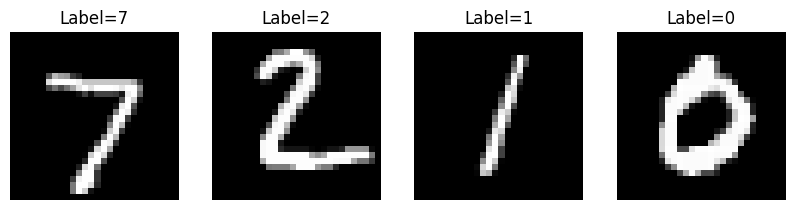


Visualizing convolution layer outputs for 4 images from the first layer (channel=0,1,...).


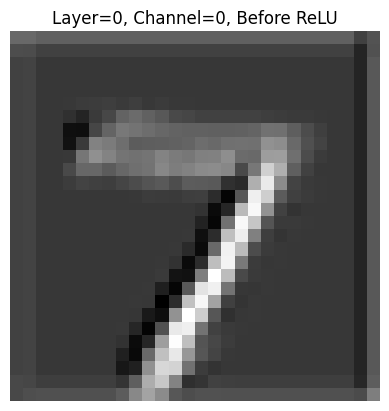

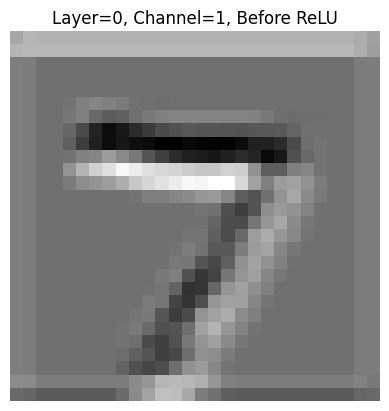

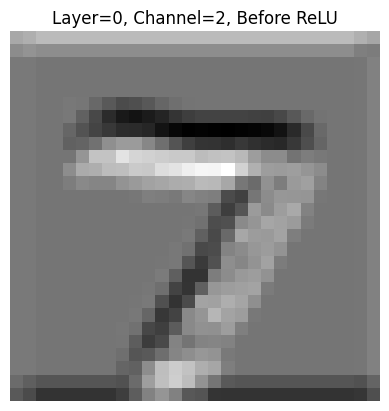

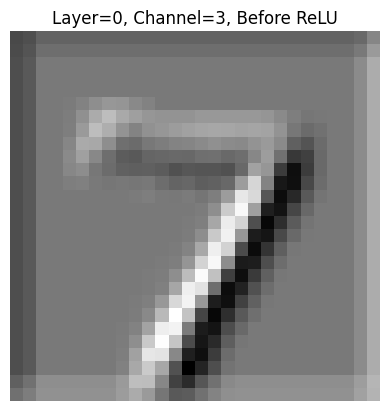

In [ ]:
"""
This snippet orchestrates the main flow for ex_4:
1) Loads MNIST data, splits into train/val/test.
2) Creates and trains three architectures:
   a) SingleConvNet
   b) DoubleConvNet (no dropout)
   c) DoubleConvNet with 50% dropout
3) Compares training with batch_size=50 and batch_size=100, measuring:
   - Time and number of iterations to reach 0.99 validation accuracy (if achieved)
   - Final best validation accuracy
4) For the architecture with the best balanced accuracy, displays:
   - Convolution filter weights
   - 4 visualizations (before and after ReLU) from the first convolution layers
   - The original images used for those visualizations
"""

def main():
    """
    Main function that executes all ex_4 steps:
    - Loads MNIST train/test data and splits it (90%/10%) for train/val.
    - Instantiates SingleConvNet, DoubleConvNet, DoubleConvNetDropout.
    - For each architecture, trains twice (batch_size=50 and batch_size=100).
      Tracks how many iterations and how long until val_acc >= 0.99 (or max_epochs).
    - Chooses the best architecture by balanced accuracy on the validation set.
    - Visualizes that architecture's filters and sample convolution outputs.
    :return: None (prints results and shows plots).
    """
    import torch
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    transform = get_transforms()
    mnist_full_train = load_mnist_dataset(transform, train=True)
    mnist_test = load_mnist_dataset(transform, train=False)
    train_subset, val_subset = split_train_validation(mnist_full_train, train_ratio=0.9)
    batch_sizes = [50, 100]
    train_loaders = {}
    val_loaders = {}
    for bs in batch_sizes:
        train_loaders[bs], val_loaders[bs], _ = create_dataloaders(train_subset, val_subset, mnist_test, batch_size=bs)

    test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

    archs = {
        "SingleConv": single_conv_net(),
        "DoubleConv": double_conv_net(add_dropout=False),
        "DoubleConvDropout": double_conv_net(add_dropout=True)
    }
    criterion = torch.nn.CrossEntropyLoss()
    max_epochs = 20
    target_acc = 0.99

    results = {}
    for arch_name, arch_model in archs.items():
        results[arch_name] = {}
        for bs in batch_sizes:
            if arch_name == "SingleConv":
                model_copy = type(arch_model)()
            else:
                is_dropout = arch_model.dropout.__class__ != torch.nn.Identity
                model_copy = type(arch_model)(is_dropout)
            model_copy.load_state_dict(arch_model.state_dict())
            model_copy.to(device)
            optimizer = torch.optim.Adam(model_copy.parameters(), lr=1e-3)

            print(f"\n=== Training {arch_name} with batch_size={bs} ===")
            best_val, iters, train_time = train_ex4(
                model_copy, train_loaders[bs], val_loaders[bs],
                optimizer, criterion, max_epochs=max_epochs,
                target_val_accuracy=target_acc, verbose=True
            )
            acc_val, bal_acc_val = evaluate_ex4(model_copy, val_loaders[bs])
            print(f"Batch={bs}, Achieved ValAcc={acc_val:.4f}, BalValAcc={bal_acc_val:.4f}, Time={train_time:.2f}s, Iters={iters}")
            results[arch_name][bs] = {
                "model": model_copy,
                "best_val": best_val,
                "iters": iters,
                "time": train_time,
                "acc_val": acc_val,
                "bal_acc_val": bal_acc_val
            }

    best_arch = None
    best_bal_acc = 0.0
    best_bs = None
    for arch_name in results:
        for bs in results[arch_name]:
            if results[arch_name][bs]["bal_acc_val"] > best_bal_acc:
                best_bal_acc = results[arch_name][bs]["bal_acc_val"]
                best_arch = arch_name
                best_bs = bs

    print(f"\n=== Best architecture by Balanced Accuracy on Validation is {best_arch}, batch_size={best_bs}, bal_acc_val={best_bal_acc:.4f} ===")

    final_model = results[best_arch][best_bs]["model"]
    final_test_acc, final_test_bal = evaluate_ex4(final_model, test_loader)
    print(f"Test Accuracy={final_test_acc:.4f}, Test Balanced Accuracy={final_test_bal:.4f}")

    print("\nVisualizing filters of the best architecture:")
    visualize_filters(final_model, layer_index=0)

    single_batch_loader = iter(test_loader)
    images_batch, labels_batch = next(single_batch_loader)
    print("Displaying sample original images used for conv activation visualization:")
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, 4, figsize=(10, 3))
    for idx, ax in enumerate(axes):
        ax.imshow(images_batch[idx].squeeze(), cmap="gray")
        ax.set_title(f"Label={labels_batch[idx].item()}")
        ax.axis("off")
    plt.show()

    print("\nVisualizing convolution layer outputs for 4 images from the first layer (channel=0,1,...).")
    for i in range(4):
        image_conv(final_model, images_batch, layer_index=0, channel_index=i, after_relu=False)
        image_conv(final_model, images_batch, layer_index=0, channel_index=i, after_relu=True)

if __name__ == "__main__":
    main()